# Code with explicit math imlpementation


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
import time
import kagglehub
import json
from tqdm import tqdm
import os
from tensor_decompositions import compute_error

In [35]:
reynolds_numbers = [8000]
paths = [f"sharmapushan/hydrogen-jet-{re}" for re in reynolds_numbers]
data_paths = [kagglehub.dataset_download(name) for name in paths]
data_path = data_paths[0]
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)
subsample_x, subsample_y = 5,5
Nx, Ny = metadata['global']['Nxyz']
n_snapshots = metadata['global']['snapshots'] - 1
Nx_sub = Nx // subsample_x
Ny_sub = Ny // subsample_y

component_names = ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']
species_names = [cname[1:] for cname in component_names]
n_species = len(component_names)
molar_masses = {'YH': 1.0, 'YH2': 2.0, 'YO': 8.0, 'YO2': 16.0, 'YOH': 9.0, 'YH2O': 10.0, 'YHO2': 17.0, 'YH2O2': 18.0}
file_key_map = file_key_map = {'YH': 'YH filename', 'YH2': 'YH2 filename', 'YO': 'YO filename', 'YO2': 'YO2 filename',
                                'YOH': 'YOH filename', 'YH2O': 'YH2O filename', 'YHO2': 'YHO2 filename', 'YH2O2': 'YH2O2 filename'
}
Lx, Ly = 12.5, 15.6
print(f"Grid: {Nx}x{Ny}, Subsampled: {Nx_sub}x{Ny_sub}")
tensor_ = np.zeros((Ny_sub, Nx_sub, n_species, n_snapshots))

for t_idx in tqdm(range(n_snapshots)):
    for new_idx, (comp_name, orig_idx) in enumerate(zip(component_names, range(n_species))):
        filename_key = file_key_map[comp_name]
        filename = metadata['local'][t_idx][filename_key]
        data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
        molar_data = data / molar_masses[comp_name]
        tensor_[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]
print(tensor_.shape)
print("Data loading complete!")
tensor_combustion = tensor_[:, :, :, :]


Grid: 1600x2000, Subsampled: 320x400


100%|██████████| 200/200 [00:04<00:00, 42.66it/s]

(400, 320, 8, 200)
Data loading complete!


In [36]:
def select_rank_by_ratio(array, varepsilon):
    sorted_array = np.sort(array)[::-1]
    total_energy = np.sum(sorted_array)
    cumulative_energy = np.cumsum(sorted_array)
    num_components = np.sum(cumulative_energy <= varepsilon * total_energy) + 1
    return min(num_components, len(array))

In [42]:
# Sequentially truncated 
start_t = time.time()
factors_st = []
current_tensor = tensor_combustion.copy()

for mode in range(current_tensor.ndim):
    unfolded = tl.unfold(current_tensor, mode)
    g_matrix = unfolded @ unfolded.T
    eigenvalues, eigenvectors = np.linalg.eigh(g_matrix)
    eigenvalues = np.sqrt(np.abs(eigenvalues))
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    trunc_idx = select_rank_by_ratio(eigenvalues, 0.99)
    print(trunc_idx)
    U_trunc = eigenvectors[:, :trunc_idx].real
    current_tensor = tl.tenalg.mode_dot(current_tensor, U_trunc.T, mode)
    factors_st.append(U_trunc)
core_st = current_tensor
end_t = time.time()
st_time = end_t - start_t
print(f"stHOSVD computed in {st_time:.2f} seconds")
reconstruction_st = tl.tenalg.multi_mode_dot(core_st, factors_st, [0,1,2,3])
print(np.allclose(reconstruction_st, tensor_combustion))
error_st = compute_error(tensor_combustion, reconstruction_st)
print(f"stHOSVD relative error: {error_st:.6f}")

93
53
3
187
stHOSVD computed in 1.30 seconds
False
stHOSVD relative error: 0.011799


In [43]:
# Subsampled 
start_t = time.time()
factors_sub = []

for mode in range(tensor_combustion.ndim):
    unfolded = tl.unfold(tensor_combustion[tuple(slice(None) if d == mode else slice(None, None, 2) for d in range(tensor_combustion.ndim))], mode)
    print(unfolded.shape)
    g_matrix = unfolded @ unfolded.T
    eigenvalues, eigenvectors = np.linalg.eigh(g_matrix)
    eigenvalues = np.sqrt(np.abs(eigenvalues))
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    trunc_idx = select_rank_by_ratio(eigenvalues, varepsilon=0.9999)
    print(trunc_idx)
    U_trunc = eigenvectors[:, :trunc_idx].real
    factors_sub.append(U_trunc)
core_sub = tl.tenalg.multi_mode_dot(tensor_combustion, [f.T for f in factors_sub], modes=list(range(tensor_combustion.ndim)))
end_t = time.time()
sub_time = end_t - start_t
print(f"sub HOSVD computed in {sub_time:.2f} seconds")
print(f"Subsampled HOSVD computed in {sub_time:.2f} seconds")
reconstruction_sub = tl.tenalg.multi_mode_dot(core_sub, factors_sub, [0,1,2,3])
print(np.allclose(reconstruction_sub, tensor_combustion))
error_sub = compute_error(tensor_combustion, reconstruction_sub)
print(f"Subsampled HOSVD relative error: {error_sub:.6f}")


(400, 64000)
182
(320, 80000)
97
(8, 3200000)
6
(200, 128000)
200
sub HOSVD computed in 1.55 seconds
Subsampled HOSVD computed in 1.55 seconds
False
Subsampled HOSVD relative error: 0.213705


In [44]:
# Subsampled 
start_t = time.time()
factors_sub = []

for mode in range(tensor_combustion.ndim):
    unfolded = tl.unfold(tensor_combustion[tuple(slice(None) if d == mode else slice(None, None, 2) for d in range(tensor_combustion.ndim))], mode)
    U, S, Vh = np.linalg.svd(unfolded, full_matrices=False)
    trunc_idx = select_rank_by_ratio(S, varepsilon=0.99)
    print(trunc_idx)
    U_trunc = U[:, :trunc_idx].real
    factors_sub.append(U_trunc)
core_sub = tl.tenalg.multi_mode_dot(tensor_combustion, [f.T for f in factors_sub], modes=list(range(tensor_combustion.ndim)))
end_t = time.time()
sub_time = end_t - start_t
print(f"sub HOSVD computed in {sub_time:.2f} seconds")
print(f"Subsampled HOSVD computed in {sub_time:.2f} seconds")
reconstruction_sub = tl.tenalg.multi_mode_dot(core_sub, factors_sub, [0,1,2,3])
print(np.allclose(reconstruction_sub, tensor_combustion))
error_sub = compute_error(tensor_combustion, reconstruction_sub)
print(f"Subsampled HOSVD relative error: {error_sub:.6f}")


60
41
3
171
sub HOSVD computed in 8.90 seconds
Subsampled HOSVD computed in 8.90 seconds
False
Subsampled HOSVD relative error: 0.245469


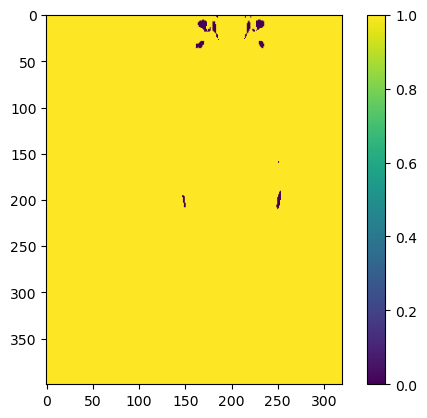

In [55]:
plt.imshow(reconstruction_st[:, :, 0, 0] > -0.00001)
plt.colorbar()